# Jane Austen Works Embedding

<a href="https://colab.research.google.com/github/fmcooper/austen-embedding/blob/master/austen-embedding.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

---

In [15]:
import sys
import numpy as np
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import multiprocessing
import gensim
from gensim.models.phrases import Phrases, Phraser # for bigram detection
from gensim.models import Word2Vec
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords



print("\n---------- versions ----------\n")
print("python version: " + sys.version)
print("pandas version: " + pd.__version__)
print("numpy version: " + np.__version__)
print("matplotlib version: " + mpl.__version__)
print("gensim version: " + gensim.__version__)
print("sklearn version: " + sklearn.__version__)
print("nltk version: " + nltk.__version__)
print()

from google.colab import drive
drive.mount('/content/gdrive')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!

---------- versions ----------

python version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
pandas version: 0.24.2
numpy version: 1.16.3
matplotlib version: 3.0.3
gensim version: 3.6.0
sklearn version: 0.20.3
nltk version: 3.2.5

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Downloading the data

In [16]:
print("\n---------- downloading data ----------\n")
DATA_PATHS = ['/content/gdrive/My Drive/Colab/austen-embedding/data/austen-emma-754.txt', \
             '/content/gdrive/My Drive/Colab/austen-embedding/data/austen-northanger-755.txt', \
             '/content/gdrive/My Drive/Colab/austen-embedding/data/austen-persuasion-756.txt', \
             '/content/gdrive/My Drive/Colab/austen-embedding/data/austen-pride-757.txt', \
             '/content/gdrive/My Drive/Colab/austen-embedding/data/austen-sense-758.txt']

# bundle all book texts together
content = ""
for PATH in DATA_PATHS:
    with open(PATH, 'r') as file:
        content = content + file.read() + "\n"
    


---------- downloading data ----------



### Exploring the data

In [17]:
print("\n---------- exploring the data ----------\n")    

print("\nbeginning of content: \n" + content[:400])
print("\nend of content: \n" + content[-400:])


---------- exploring the data ----------


beginning of content: 
[pg/etext94/emma10.txt]

Emma, by Jane Austen
August, 1994  [Etext #158]

This text is in the PUBLIC DOMAIN.

VOLUME I

CHAPTER I

Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her. 

She was the youngest of the

end of content: 
ong family affection would
naturally dictate;--and among the merits and the happiness
of Elinor and Marianne, let it not be ranked as the least
considerable, that though sisters, and living almost within
sight of each other, they could live without disagreement
between themselves, or producing coolness between their husbands.

THE END

End of The Project Gutenberg Etext of Sense and Sensibility





### Preparing data

In [18]:
print("\n---------- preparing data ----------\n")

# split into sentences
sent = [nltk.sent_tokenize(content)]
sent = np.array(sent).T

# removing punctuation and stop words, transforming to lower case and lemmatising
tokenizer = nltk.RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer() 
sentences = []
index = 0
for s in sent:
    wordsList = tokenizer.tokenize(s[0])
    wordsList = [lemmatizer.lemmatize(w.lower()) for w in wordsList if w not in stop_words]
    sentences.append(wordsList)
    
    
print("\n---------- bigrams ----------\n")
phrases = Phrases(sentences, min_count=30, progress_per=10000)
# Phraser() cuts down memory needed from phrases
bigram = Phraser(phrases)
sentences = bigram[sentences]
   
    
print("\nFirst few sentences: \n" + str(np.array(sentences[:5])))



---------- preparing data ----------


---------- bigrams ----------


First few sentences: 
[list(['pg', 'etext94', 'emma10', 'txt', 'emma', 'jane', 'austen', 'august', '1994', 'etext', '158', 'this', 'text', 'public', 'domain'])
 list(['volume', 'i', 'chapter', 'i', 'emma', 'woodhouse', 'handsome', 'clever', 'rich', 'comfortable', 'home', 'happy', 'disposition', 'seemed', 'unite', 'best', 'blessing', 'existence', 'lived', 'nearly', 'twenty', 'one', 'year', 'world', 'little', 'distress', 'vex'])
 list(['she', 'youngest', 'two', 'daughter', 'affectionate', 'indulgent', 'father', 'consequence', 'sister', 'marriage', 'mistress', 'house', 'early', 'period'])
 list(['her', 'mother', 'died', 'long', 'ago', 'indistinct', 'remembrance', 'caress', 'place', 'supplied', 'excellent', 'woman', 'governess', 'fallen', 'little', 'short', 'mother', 'affection'])
 list(['sixteen', 'year', 'miss_taylor', 'mr_woodhouse', 'family', 'le', 'governess', 'friend', 'fond', 'daughter', 'particularly', 'emma'])

### Training the Model

In [19]:
print("\n---------- training the model ----------\n")

t = time()

# create model
cores = multiprocessing.cpu_count() 
print("Number of cores: " + str(cores) + "\n")
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

# build the vocab
w2v_model.build_vocab(sentences, progress_per=1000)

# train the model
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

time_taken = round((time() - t) / 60, 2)
print("Time to train model: " + str(time_taken) + " mins")


---------- training the model ----------

Number of cores: 2

Time to train model: 0.8 mins


Save the model to memory

In [0]:
w2v_model.init_sims(replace=True)

###Exploring the Model

In [21]:
print("\n---------- exploring the model ----------\n")

# similar words to given words
print("\nwords most similar to garden:")
print(w2v_model.wv.most_similar(positive=["garden"]))

print("\nwords most similar to love:")
print(w2v_model.wv.most_similar(positive=["love"]))

print("\nwords most similar to darcy:")
print(w2v_model.wv.most_similar(positive=["darcy"]))

print("\nwords most similar to mr_darcy:")
print(w2v_model.wv.most_similar(positive=["mr_darcy"]))


# how similar words are to each other
print("\nhow similar man is to woman: " + str(w2v_model.wv.similarity("man", 'woman')))
print("\nhow similar house is to woman: " + str(w2v_model.wv.similarity("house", 'woman')))

# which words don't match?
print("\nwhich word doesn't match out of mother, daughter and horse?: " + str(w2v_model.wv.doesnt_match(['mother', 'daughter', 'horse'])))

# analogies
print("\nwhich word is to daughter as woman is to man?: " + str(w2v_model.wv.most_similar(positive=["daughter", "woman"], negative=["man"], topn=3)))
print("\nwhich word is to son as woman is to man?: " + str(w2v_model.wv.most_similar(positive=["son", "woman"], negative=["man"], topn=3)))



---------- exploring the model ----------


words most similar to garden:
[('house', 0.9915000200271606), ('cottage', 0.9891461133956909), ('gate', 0.9880467653274536), ('lane', 0.9866393804550171), ('road', 0.9859143495559692), ('party', 0.9840120077133179), ('village', 0.9835891127586365), ('park', 0.982439398765564), ('quitted', 0.9823840260505676), ('reached', 0.9819644689559937)]

words most similar to love:
[('ought', 0.9934970140457153), ('certainly', 0.9909327030181885), ('deceived', 0.9909183979034424), ('wish', 0.9906458854675293), ('my', 0.9905052781105042), ('blame', 0.9903041124343872), ('every_body', 0.9902459383010864), ('really', 0.9898450374603271), ('silly', 0.9897284507751465), ('understand', 0.9895881414413452)]

words most similar to darcy:
[('observe', 0.9882214665412903), ('caroline', 0.9876754283905029), ('mentioned', 0.9856893420219421), ('observed', 0.9848013520240784), ('george', 0.984695553779602), ('bennet', 0.9842727184295654), ('fair', 0.9840996861457825

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


t-SNE visualization - uses an algorithm to represent high-dimensional space in low dimensions.

Had to change n_components in PCA call

From: https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=16).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))


10 most similar words to house vs 10 random ones



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


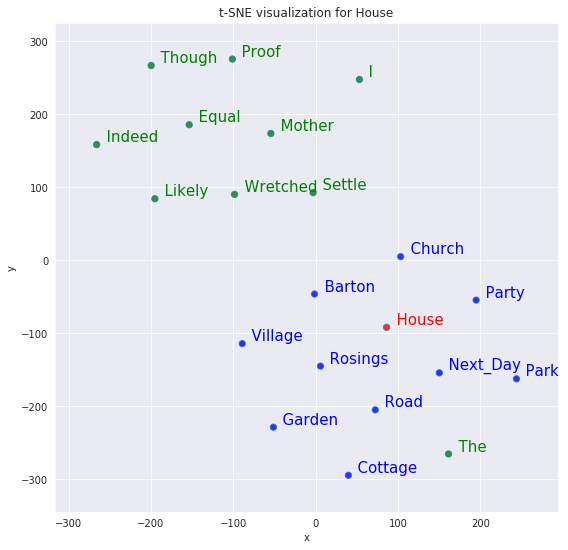

In [23]:
print("\n10 most similar words to house vs 10 random ones\n")

# num_sentences = len(sentences)
# random_words = []

# from numpy.random import randint
# for x in range(10):
#     random_sentence = sentences[randint(num_sentences)]
#     num_words = len(random_sentence)
#     random_words.append(random_sentence[randint(num_words)])
    
# print(random_words)

random_words = ['likely', 'i', 'mother', 'equal', 'settle', 'the', 'though', 'indeed', 'proof', 'wretched']

tsnescatterplot(w2v_model, 'house', random_words)


10 most similar words to house vs 10 most dissimilar ones



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


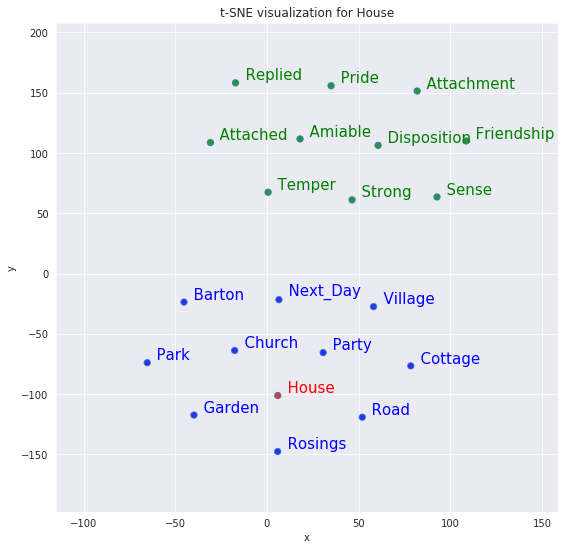

In [24]:
print("\n10 most similar words to house vs 10 most dissimilar ones\n")

tsnescatterplot(w2v_model, 'house', [i[0] for i in w2v_model.wv.most_similar(negative=["house"])])